In [1]:
import numpy as np
import pyvista as pv

import structgeo.model as geo
import structgeo.plot as geovis
from structgeo.probability import SedimentBuilder

# Static plots:
pv.set_jupyter_backend("static")
# Dynamic plots:
# pv.set_jupyter_backend('trame')
# pv.set_jupyter_backend('html')
WS = (600, 400)  # Set a custom window size to be reused in most plots

## GeoModel
The GeoModel class provides the framework to construct 3D geological models from a defined sequence of GeoProcesses.

- **Flexible Grid Definition**: Define your grid by specifying bounds. Provide a single min/max tuple for a cubic grid or distinct min/max tuples for each axis to create a rectangular prism.
- **Adjustable Resolution**: Control the granularity of the grid with the resolution parameter, which sets the number of divisions along each axis. Each axis can have a different resloution.
- **Data Type**: Optimize memory usage and computation speed by specifying the data type of the grid values, with np.float32 as the default

In [2]:
# Cubic model
bounds = (-10, 10)
resolution = 128
model = geo.GeoModel(bounds=bounds, resolution=resolution)

# Alternatively, you can specify different bounds and resolution for each axis
bounds = ((-20, 20), (-20, 20), (-10, 10))
resolution = (128, 128, 64)
model = geo.GeoModel(bounds=bounds, resolution=resolution)

## GeoProcess

*GeoProcess* is a base class for modeling geological events in the GeoModel framework. There are *three* types of geological modifications: `Deposition`, `Transformation`, and `CompoundProcess`

The Transformations are operations that modify the mesh geometry and can be reversed in time. The Depositions are operations that add or remove geological materials without changing the arrangement of the mesh points. Compound processes are a combination of one or more GeoProcess. Think of it a sub-sequence of geological events that are applied together.

The reasoning for this division is explained further below.

There are two types of geological modifications: Depositions and Transformations

#### Depositions:
These processes add or remove geological materials (e.g., rock layers, dikes) to the model without changing the spatial coordinates of the mesh.

Examples:

**Layer**: Adds horizontal layers of material, defined by a base, width, and material value.

**Dike**: Inserts a vertical or angled planar feature defined by strike, dip, and width.

**Sedimentation**: Simulates the accumulation of sediment layers, where each layer's thickness can be randomly determined.

#### Transformations:
These processes alter the geometry of the mesh (the spatial coordinates) to simulate geological forces, without changing the properties assigned to the mesh points.

Examples:

**Fold**: Deforms the mesh to create a fold structure, defined by a wavelength, amplitude, and orientation.

**Fault**: Displaces the mesh along a planar surface, defined by strike, dip, and offset.

#### Compound Processes:
These processes combine multiple GeoProcesses into a single event, they may also include other Compound Processes.

Examples:

**Laccolith**: A lacolith deposits new intrusive material while also deforming the mesh around it, creating both a deposition and deformation.

#### Frame Convention: 

**North** corresponds to the positive Y-axis.

Transformations consider this orientation when applying modifications like strike and dip. Strike is measured from the north in a clockwise direction, and dip is the angle from the horizontal plane. PyVista which is used for visualization can show the x,y,z axes in reference to the model. This is done in the code by adding the axes actor to the plotter.

#### Building Geological History:
A list of GeoProcesses can be added to a GeoModel to build up a history of events. Once a full history is defined, the model can be computed to visualize the cumulative effects of the geological processes.

History Management: Add one or more events to the history using the add history method. The order of the events in the history list determines the sequence in which they are applied to the model. To clear the history use the clear history method. This will remove all events from the history list but not change the model data until it is recomputed.

#### Model Computation
<img src="https://i.imgur.com/sPS9JmN.png" width="1200" >

The model has the restriction that we are on a meshgrid in the present where all the points are evenly spaced. However any Transformation process will alter the grid, making the points unevenly spaced. In order to correctly apply Deposition events, we need to know the mesh points in the past, which is done be reversing the history of Transformations. Intermediate states are cached along the way as snapshots in the time reversal process. The Transformations implicitly do not rely on the past state of the model, only the current state. This is why they can be reversed in time.

The Deposition events rely on the past state of the model. For example a Dike is deposited only where there is already existing material, which can not be known without having information about the past. For this reason these events are processed as part of the forward time computation, using the cached snapshots of the model at each step.

### Bedrock and Sediment Layers
Bedrock is an optional basement layer for the model, extending infinitely downard for a base level.

Sedimentation is a layer a stack of layers that are deposited starting from either the lowest empty space in the mesh or from a specified base. The layering effect is achieved by specifying a list of values for the sediment layers and a list of thicknesses. If too few thicknesses are specified for the list of values, the thickness list cycles again.

In [3]:
bedrock = geo.Bedrock(base=-5, value=1)
sediment0 = geo.Sedimentation(value_list=[2, 3, 4, 5], thickness_list=[1, 2])

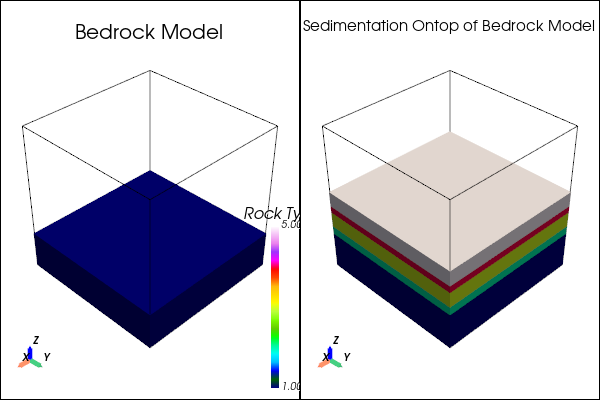

GeoModel(name=model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(128, 128, 128))

In [4]:
p = pv.Plotter(shape=(1, 2))

model = geo.GeoModel(bounds=(-10, 10), resolution=128)
model.clear_history()
# Add a base layer of bedrock
model.add_history(bedrock)
model.compute_model()
p.subplot(0, 0)
geovis.volview(model, plotter=p)
p.add_title(title="Bedrock Model", font_size=8)

model.add_history(sediment0)
model.compute_model()
p.subplot(0, 1)
geovis.volview(model, plotter=p)

p.add_title(title="Sedimentation Ontop of Bedrock Model", font_size=6)
p.window_size = WS
p.show()

display(model)

 ### Model Html Table
 The model specifications can be viewed in Jupyter by calling `display()` on the object.

### Sedimentation
The basic sedimentation process builds layers up vertically from either a specified base or the lowest non-rock value in the model. 

The number of layers is determines by the number of values passed in the values_list.
The thickness of each layer is controlled by the corresponding thickness_list, however if fewer thicknesses than values are passed, the thickness list will repeat.

Example:
Pass values `[1,2,3]` and thicknesses `[1,2]` to create a model with 3 layers of values 1,2,3 with thicknesses 1,2,1.

If no base is specified then the lowest non-rock value in the model is used as the base. It is worth noting that if the model is empty then it will build from the lowest z-value meshpoint.


In [5]:
# Create a list of values that represent different types of sedimentary rocks.
sediment_rock_types = list(range(6, 9))
average_thickness = 2
variation = np.random.normal(loc=0, scale=0.5, size=len(sediment_rock_types))
thickness_list = average_thickness + variation
# No base is specified, triggering an automatic base at lowest point with rock value in the model.
sediment1 = geo.Sedimentation(
    value_list=sediment_rock_types, thickness_list=thickness_list
)

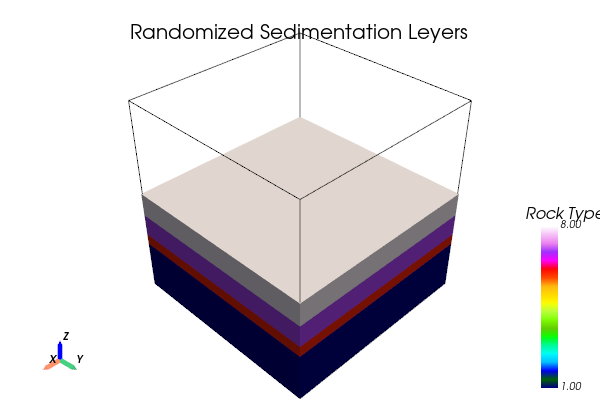

In [6]:
model.clear_history()
model.add_history(bedrock)
model.add_history(sediment1)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(title="Randomized Sedimentation Leyers", font_size=8)
p.show()

#### Sediment Builder
To help with quickly generating sedimentation layers the helper class `SedimentBuilder` is provided. This class has a method `build_layers` which will generate a list of values and thicknesses based on the number of layers and the range of values and thicknesses passed. This can be used to quickly generate a list of values and thicknesses to pass to the sedimentation process.

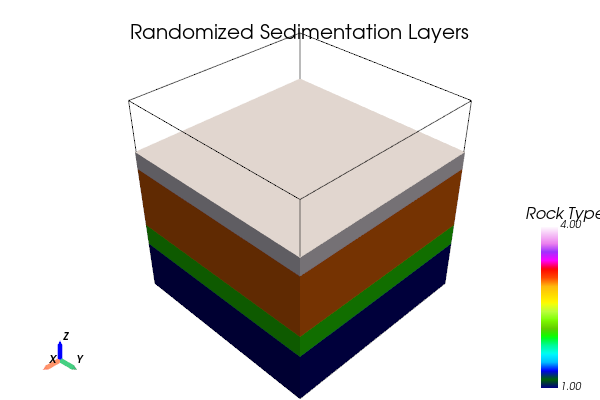

GeoModel(name=model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(128, 128, 128))

In [7]:
sb = SedimentBuilder(
    start_value=2, total_thickness=10, min_layers=3, max_layers=6, std=0.5
)

layer_vals, layer_thicknesses = sb.get_layers()
sediment2 = geo.Sedimentation(value_list=layer_vals, thickness_list=layer_thicknesses)

model.clear_history()
model.add_history(bedrock)
model.add_history(sediment2)
model.compute_model()

p = geovis.volview(model)

p.window_size = WS

p.add_title(title="Randomized Sedimentation Layers", font_size=8)

p.show()
model

### Dikes (Planar)
A DikePlane is a simple planar intrusion of other rocktype into the model. Due to gravity, we expect dikes to fill in a fissure in the rock without extending into the air. This can be accomplished by specifying that the dike replaces existing rock only.

The strike angle is clockwise from north using the local coordinates origin specified by the origin parameter. The dip angle is how steep the dike is from the horizontal plane. The width is the thickness of the dike. The value is the rocktype.

In [8]:
dike = geo.DikePlane(strike=30, dip=75, width=3, origin=(-6, 8, 0), value=9)

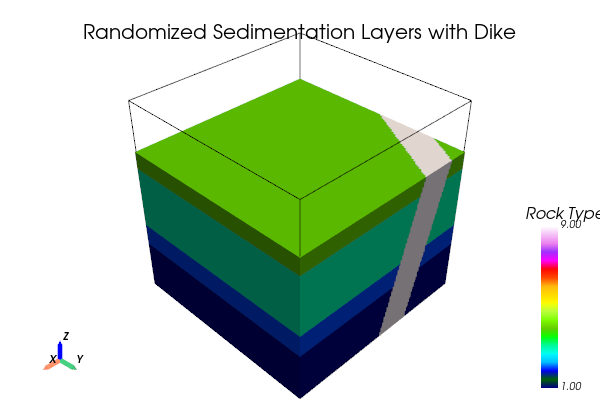

GeoModel(name=model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(128, 128, 128))

In [9]:
history = [bedrock, sediment2, dike]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(title="Randomized Sedimentation Layers with Dike", font_size=8)
p.show()
model

#### Thickness Modifier
A thickness modifying function can be passed that will adjust dike thickness based on the local x,y frame of the dike plane. This could be used to limit the range of the dike, create a wedge, or other effects.

Below is shown an example of a dike that eventually ends along its plane due to the thickness modifier going below zero

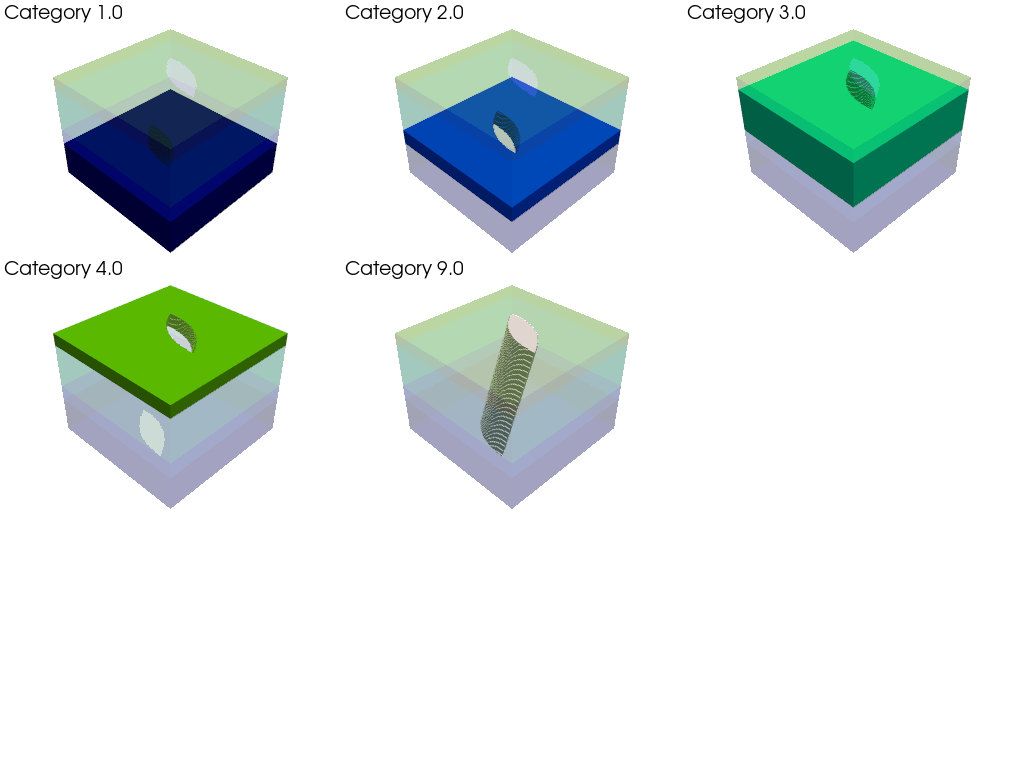

GeoModel(name=model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(128, 128, 128))

In [10]:
from structgeo.probability import FourierWaveGenerator
func = FourierWaveGenerator(2, frequency=1/15, smoothness=1).generate()

def width_func(x, y):
    return 1-(y/5)**2
    
dike = geo.DikePlane(strike=30, dip=75, width=3, origin=(-0, 0, 0), value=9, thickness_func=width_func)

history = [bedrock, sediment2, dike]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(title="Randomized Sedimentation Layers with Dike", font_size=8)
p = geovis.categorical_grid_view(model)
p.show()
model

### Dike Columns

Dike columns are a cylindrical model for an intrusion. They are specified by an origin point at the center top of the column and have an elliptical cross section defined by a diameter and the scaling of the minor axis: $\frac{\text{minor}}{\text{major}}$. By default the y-axis is the major axis and the x-axis is the minor axis. The configuration can be rotated counter clockwise. The column will extend infinitely downwards unless a depth is specified, while it may also extend into the air unless clipped using the clip parameter. 

In the case where a non-vertical column is desired, applying a change of coordinates using a rotation transformation is recommended.

In [11]:
col = geo.DikeColumn(
    origin=(0, 2, 2),
    diam=5,
    minor_axis_scale=0.6,
    rotation=30,
    depth=8,
    value=11,
    clip=False,
)

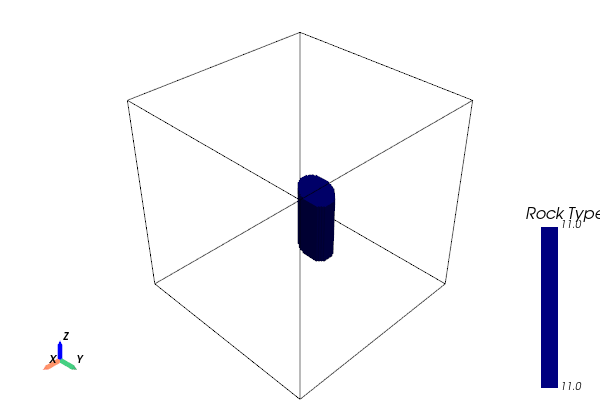

In [12]:
history = [bedrock, sediment2, dike, col]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model, threshold=11)
p.window_size = WS
p.show()

# Change of Coordinates and Custom Compound Processes Tricks

Any feature can be applied with a rotation using a tilted change of coordinates. This reduces the number of parameters for a single feature by allowing a user to construct a composite feature on a as needed basis. The `CompoundProcess` class can be used to combine multiple features into a single feature.

Alternatively a new named and parameterized class can be made that inherits the compound class, the only requirement is that `self.history` contains a history of subprocesses for the new compound class. The `geo.CompoundClass` functions as a wrapper for the history of the sub processes. This can be used to parameterize a new process composed of atomic base library processes (the `Deposition` and `Transformation` classes).

Note that the result is the same between the two but the compound process is parameterized, repeatable, and amenable to introduction into random parameter generation schemes.

In [13]:
# Using individual deposition and transformation processes
rot = geo.Rotate(axis=(1, 1, 1), angle=45)
rot_inv = geo.Rotate(axis=(1, 1, 1), angle=-45)
col = geo.DikeColumn(
    origin=(0, 0, 0), diam=5, minor_axis_scale=0.6, rotation=30, value=10, clip=False
)


# Supposing we want to make a new parameterized class to parameterize creation of tilted columns
class MyDikeColumn(geo.CompoundProcess):
    def __init__(
        self, origin, diam, minor_axis_scale, rotation, axis, axis_rot, value, clip
    ):
        self.col = geo.DikeColumn(
            origin=origin,
            diam=diam,
            minor_axis_scale=minor_axis_scale,
            rotation=rotation,
            value=value,
            clip=clip,
        )
        self.rotate = geo.Rotate(axis=axis, angle=axis_rot)
        self.rotate_inv = geo.Rotate(axis=axis, angle=-axis_rot)
        self.history = [self.rotate, self.col, self.rotate_inv]


# Now we can create a tilted column with the new class
my_col = MyDikeColumn(
    origin=(0, 0, 0),
    diam=5,
    minor_axis_scale=0.6,
    rotation=30,
    axis=(1, 1, 1),
    axis_rot=45,
    value=10,
    clip=False,
)

#### Demonstration of Equivalence

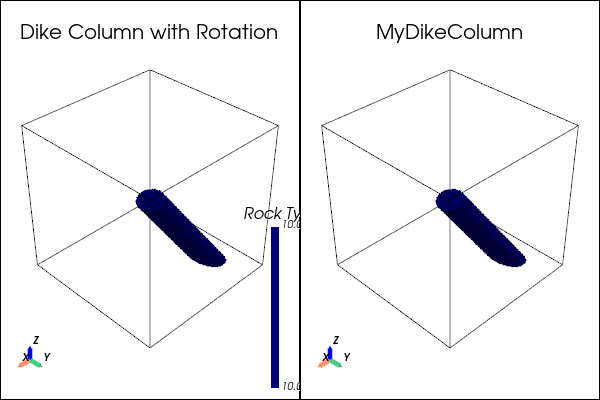

In [14]:
p = pv.Plotter(shape=(1, 2))

history = [bedrock, sediment2, dike, rot, col, rot_inv]
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 0)
geovis.volview(model, threshold=10, plotter=p)
p.add_title(title="Dike Column with Rotation", font_size=8)

history = [bedrock, sediment2, dike, my_col]
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 1)
geovis.volview(model, threshold=10, plotter=p)
p.add_title(title="MyDikeColumn", font_size=8)
p.window_size = WS
p.show()

## Compound Process Summary

Because all `CompoundProcess` classes are subclasses of `GeoProcess` they can be used in the same way as any other `GeoProcess`. This means they can be added to the history of a `GeoModel` and will be applied in the order they are added. In addition, they can be used as sub-processes in other `CompoundProcess` classes, which is allows for the creation of complex tree structures of geological events to populate a history.

<img src="https://i.imgur.com/wudCw3Q.png" width="800" >

The history is actually a tree data structure, with the root node being the inital list of `GeoProcess` objects in the passed history. The `CompoundProcess` classes are the internal nodes of the tree, while the `Deposition` and `Transformation` classes are the leaves. The history is unpacked into its constituent leaves formed of `Deposition` and `Transformation` classes via a Preorder Traversal of the tree.

### Dike Hemisphere and Plugs

Two more intrusion deposition classes are provided. A `DikeHemisphere` and a `DikePlug`. The hemisphere dike is a half sphere intrusion and the plug dike is modeled as a paraboloid with a shape parameter. The surface is a revolution about the z-axis through an origin point: $f(r) = |r^{\text{shape}}|$ A high shape parameter will flatten the top, while a low shape parameter will be more conical.

These objects can be clipped to not extend into the air by setting the clip parameter to True, but for demonstration purposes the default is False.

In [15]:
hemi_up = geo.DikeHemisphere(
    origin=(0, 3, 3),
    diam=4,
    height=4,
    minor_axis_scale=0.6,
    rotation=30,
    value=10,
    clip=False,
    upper=True,
)
hemi_down = geo.DikeHemisphere(
    origin=(0, -3, 7),
    diam=4,
    height=4,
    minor_axis_scale=0.8,
    rotation=30,
    value=10,
    clip=False,
    upper=False,
)

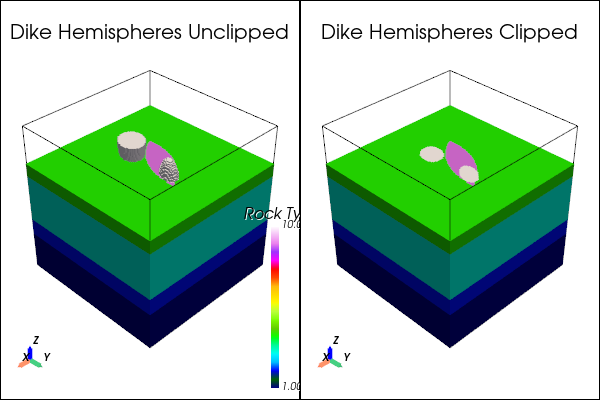

In [16]:
p = pv.Plotter(shape=(1, 2))
history = [bedrock, sediment2, dike, hemi_up, hemi_down]
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 0)
geovis.volview(model, threshold=-0.5, plotter=p)
p.add_title(title="Dike Hemispheres Unclipped", font_size=8)

# change to clipped
hemi_up.clip = True
hemi_down.clip = True
history = [bedrock, sediment2, dike, hemi_up, hemi_down]
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 1)
geovis.volview(model, threshold=-0.5, plotter=p)
p.window_size = WS
p.add_title(title="Dike Hemispheres Clipped", font_size=8)
p.show()

#### Dike Plug
Here the shape is set to a higher value which flattens the top of the plug and gives it steeper sides, it also has a 1:10 ratio of minor to major axis.

In [17]:
plug = geo.DikePlug(
    origin=(0, 0, 8),
    diam=8,
    minor_axis_scale=0.1,
    rotation=20,
    shape=10.0,
    value=10,
    clip=False,
)

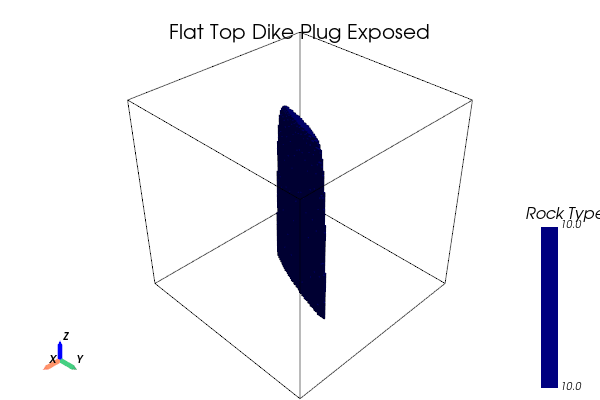

In [18]:
history = [bedrock, sediment2, dike, plug]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model, threshold=10)
p.window_size = WS
p.add_title(title="Flat Top Dike Plug Exposed", font_size=8)
p.show()

### Push

To add better kinematics to the mesh than a simple rocktype overwrite, a push process for intrusions is also provided. The push transform class mirrors the deposition class but is applied during the reverse stage. A compound process is defined that can combine the two into a push and fill intrusion process.



In [19]:
pushplug = geo.DikePlugPushed(
    diam=8,
    origin=(0, 0, -3),
    minor_axis_scale=0.3,
    rotation=0,
    shape=5.0,
    value=10,
    push=2.0,
)
hemipush = geo.DikeHemispherePushed(
    diam=8,
    origin=(0, 0, -3),
    height=4,
    minor_axis_scale=0.3,
    rotation=0,
    value=10,
    upper=True,
)

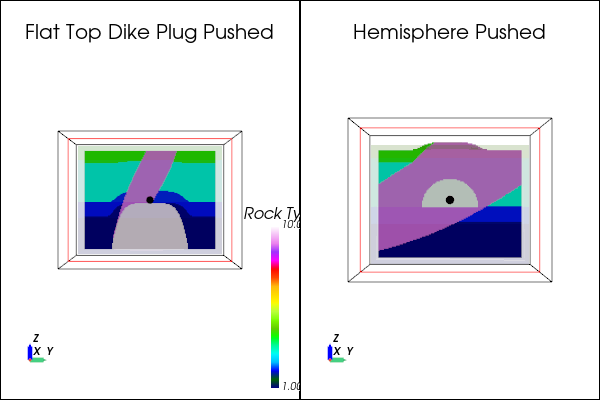

In [20]:
p = pv.Plotter(shape=(1, 2))

history = [bedrock, sediment2, dike, pushplug]
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 0)
geovis.onesliceview(model, plotter=p)
p.add_title(title='Flat Top Dike Plug Pushed', font_size=8)
p.view_yz()

history.pop()
history.append(hemipush)
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 1)
geovis.onesliceview(model, plotter=p)
p.window_size = WS
p.add_title(title='Hemisphere Pushed', font_size=8)
p.view_yz()
p.show()

### Laccoliths and Lopoliths

Combining many of these intrusive features together creates new parameterized compound classes

In [21]:
lacc = geo.Laccolith(
    origin=(0, 3, -6),
    cap_diam=15,
    stem_diam=1,
    height=2.5,
    minor_axis_scale=0.8,
    rotation=15,
    value=10,
    upper=True,
    clip=False,
)
lopo = geo.Laccolith(
    origin=(0, 3, 3),
    cap_diam=15,
    stem_diam=1,
    height=2.5,
    minor_axis_scale=0.8,
    rotation=15,
    value=10,
    upper=False,
    clip=False,
)

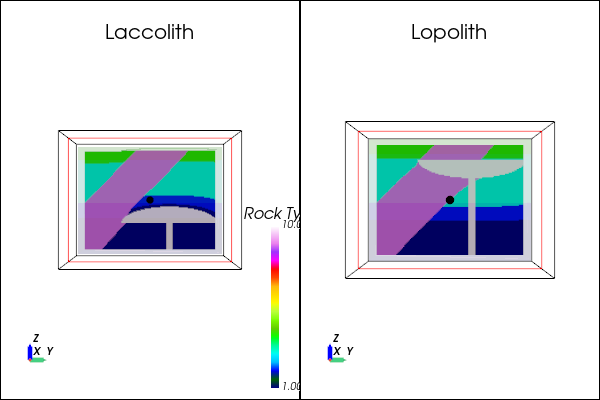

In [22]:
p = pv.Plotter(shape=(1, 2))

history[-1] = lacc
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 0)
geovis.onesliceview(model, plotter=p)
p.add_title(title="Laccolith", font_size=8)
p.view_yz()


history[-1] = lopo
model.clear_history()
model.add_history(history)
model.compute_model()
p.subplot(0, 1)
geovis.onesliceview(model, plotter=p)
p.window_size = WS
p.add_title(title="Lopolith", font_size=8)
p.view_yz()
p.show()

### Tilt
Tilt is a simple transformation that tilts the model using the standard strike, dip, and origin prarameters. This specifies the plane of rotation for the tilt. 

In [23]:
# Tilting axis laid down at edge of model (20) and tilted 15 degrees
tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))

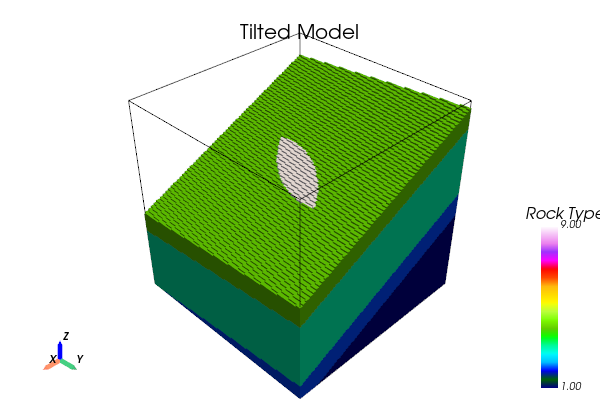

In [24]:
history = [bedrock, sediment2, dike, tilt]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(title="Tilted Model", font_size=8)
p.show()

### Deposition ontop of a model
The model lost some of the rock material that makes it interesting from the tilt. We can redeposit sediment on the layers, in the gravity orientation of the the new tilted field. Notice the dike is buried by the new sediment.

In [25]:
next_value = dike.last_value() + 1
sb = SedimentBuilder(
    start_value=next_value, total_thickness=12, min_layers=3, max_layers=6, std=0.5
)

sediment3 = geo.Sedimentation(*sb.get_layers())

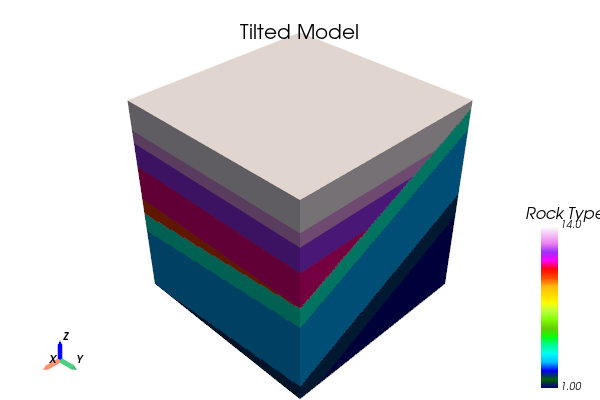

In [26]:
history = [bedrock, sediment2, dike, tilt, sediment3]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(title="Tilted Model", font_size=8)
p.show()

### Folding
Folding is one of the more complex transformations. The plane is defined by strike and dip and the fold direction/polarization is further defined by rake. It can be viewed as a wave with a direction normal to the plane and a polarization given by rake.

The default behaviour has a sinusiod with period and a shape parameter that can further alter the shape overall with a harmonic sinusoid. The tuning parameters for the wave form are period, amplitude, shape, and phase is set by origin.

Optionally a user defined function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements can be passed. This replaces the default sinusoidal wave form.

#### Strike, Dip, Rake
The two angles form the plane of the plane-wave. The polarization vector of the wave is defined by the rake angle 0 is wave motion up and down, 90 is wave motion left to right. A demonstration of the polarization effect is shown below. Note that strike 90 is East-West and so the wave travels North-South.

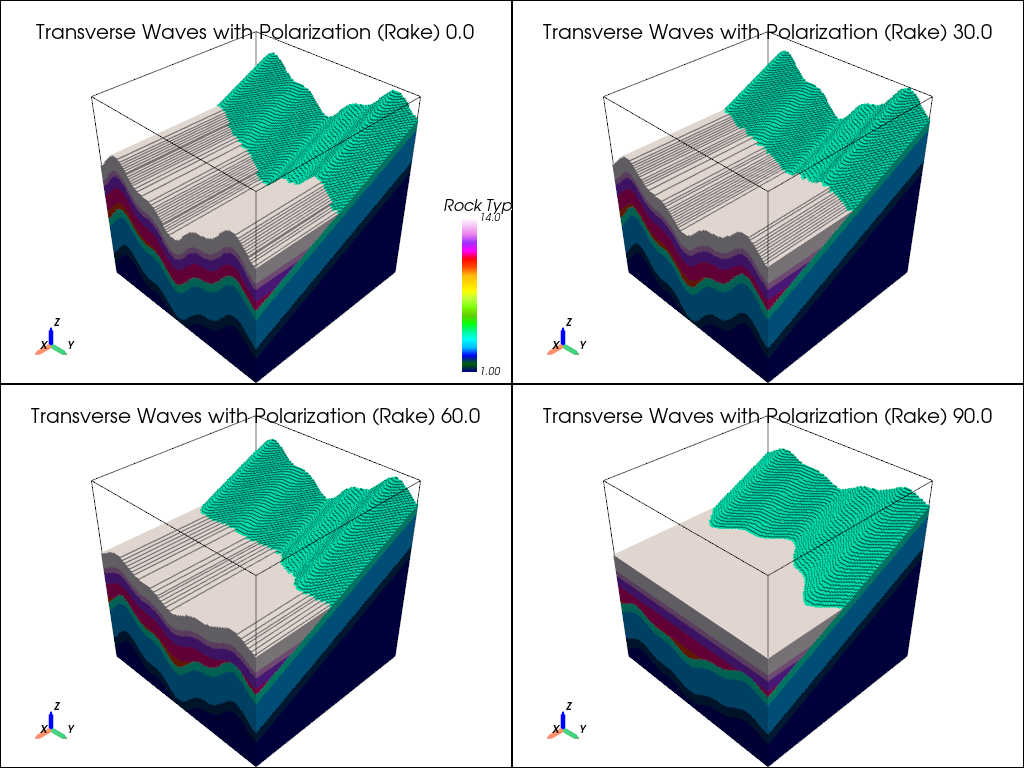

In [27]:
# Generate rake values from 0 to 90 degrees, inclusively
rake_values = np.linspace(0, 90, 4)

p = pv.Plotter(shape=(2, 2))
for i, rake in enumerate(rake_values):
    p.subplot(i // 2, i % 2)
    fold = geo.Fold(
        strike=90,
        dip=90,
        rake=rake,
        origin=(0, 0, 0),
        amplitude=4,
        period=30,
        shape=0.3,
    )
    history = [bedrock, sediment2, dike, tilt, sediment3, fold]
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(title=f"Transverse Waves with Polarization (Rake) {rake}", font_size=8)

p.show()

#### Dipping Effect
With 0 dip the folding effect is vertical instead of transverse which is hard to see without vertical layers.

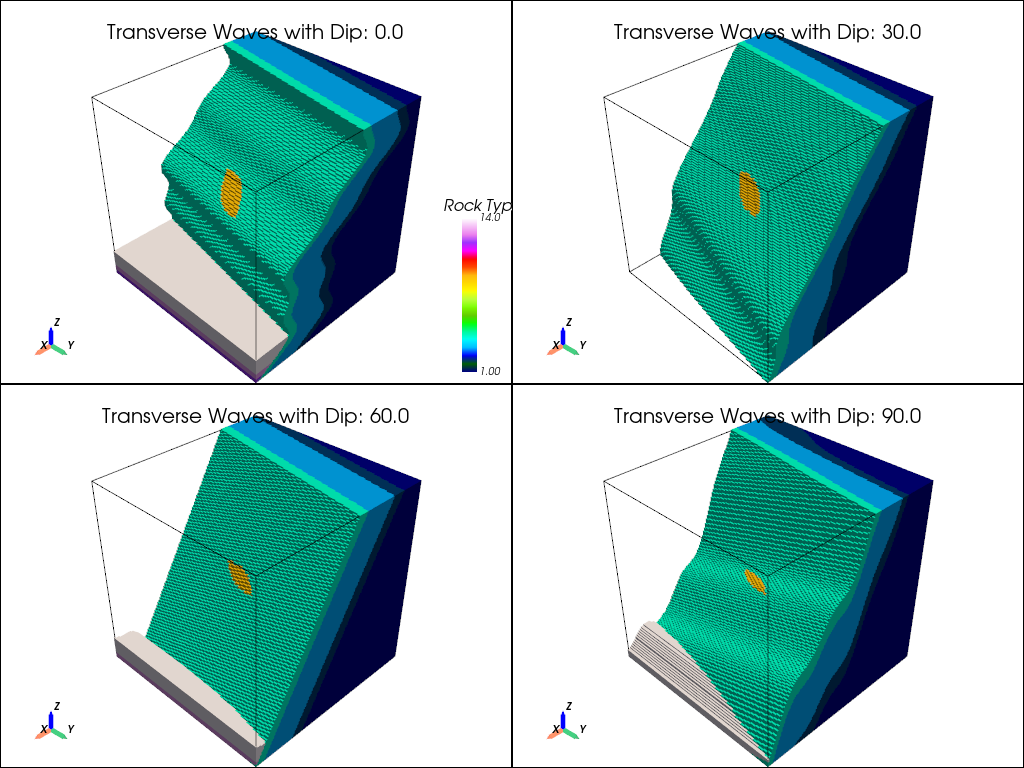

In [28]:
# Define the number of steps (including the end points)
num_steps = 4
# Generate rake values from 0 to 90 degrees, inclusively
dip_values = np.linspace(0, 90, 4)

p = pv.Plotter(shape=(2, 2))
for i, dip in enumerate(dip_values):
    p.subplot(i // 2, i % 2)
    fold = geo.Fold(
        strike=0, dip=dip, rake=0, origin=(0, 0, 0), amplitude=4, period=30, shape=0.3
    )
    tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))
    tilt2 = geo.Tilt(strike=10, dip=60, origin=(0, 5, 0))
    history = [bedrock, sediment2, dike, tilt2, sediment3, fold]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(title=f"Transverse Waves with Dip: {dip}", font_size=8)

p.show()

#### Custom Waveform
A custom waveform can be passed to the fold process. This is a function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements. This can be used to create more complex folding patterns.

The wave form is still controlled by the amplitude, period, phase arguments, the waveform does not need to be periodic, but one period or cycle maps to a value of 1.0 in the waveform function.

The probability module has some wave function generators that can be used to create custom waveforms, such as a noisy sinusoid.

The fourier series wave is an interesting option. The wave is built with a specified number of harmonics and a smoothness that is controlled by how quickly the harmonics amplitudes decay. The wave is normalized to have the same RMS as a single sin wave. In this way the amplitude and period map to the same values as the sin wave.

One could also pass in a function such as x^2 to create a parabolic fold.

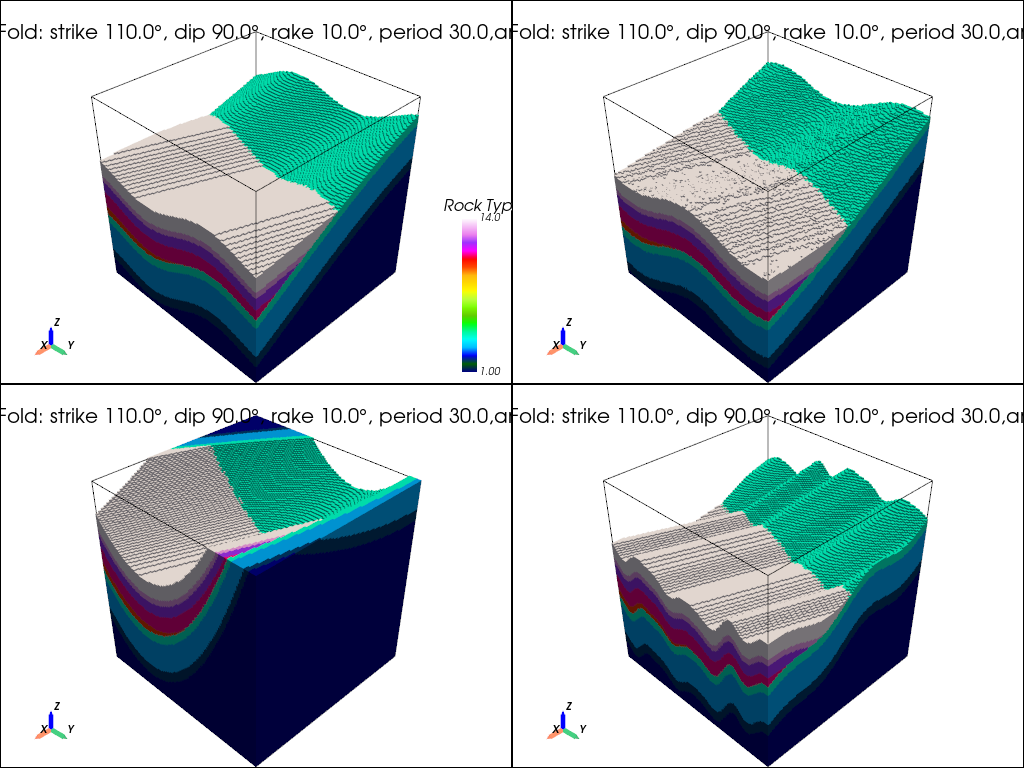

In [29]:
from structgeo.probability import FourierWaveGenerator, noisy_sine_wave

fwg = FourierWaveGenerator(num_harmonics=5, smoothness=0.8)
parabola = lambda x: -((5 * x) ** 2)
periodic_funcs = [None, noisy_sine_wave(1, 20, 0.3), parabola, fwg.generate()]

p = pv.Plotter(shape=(2, 2))
for i, fun in enumerate(periodic_funcs):
    p.subplot(i // 2, i % 2)
    # Period and amplitude modulate the passed function
    fold2 = geo.Fold(
        strike=110,
        dip=90,
        rake=10,
        origin=(0, 0, 0),
        amplitude=2,
        period=30,
        periodic_func=fun,
    )
    history = [bedrock, sediment2, dike, tilt, sediment3, fold2]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(title=f"Fold Model with Wave Function:{str(fold2)}", font_size=8)

p.show()

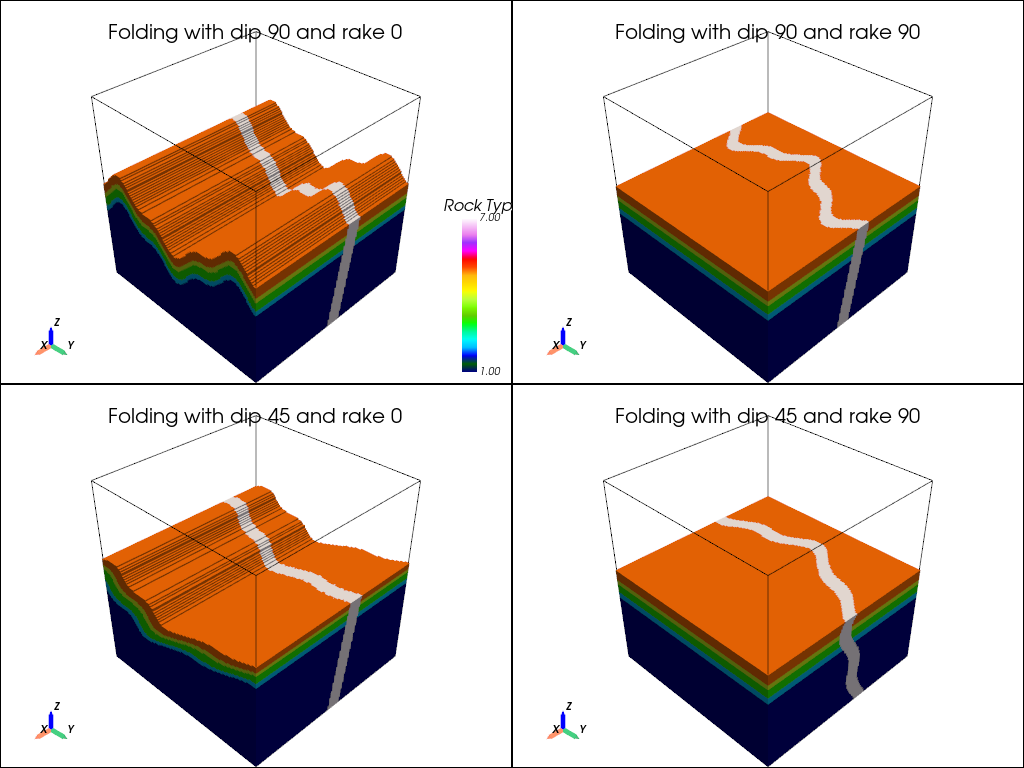

In [30]:
# Strike controls wave propogation compass direction
# Dip controls wave propogation angle from vertical
# Rake 90 = lateral polarization, Rake 0 = vertical polarization
strike_dip_rake = [(90, 90, 0), (90, 90, 90), (90, 45, 0), (90, 45, 90)]

p = pv.Plotter(shape=(2, 2))
for i, params in enumerate(strike_dip_rake):
    p.subplot(i // 2, i % 2)
    dike = geo.DikePlane(strike=10, dip=80, width=3, origin=(-6, 8, 0), value=7)
    # Make a wave traveling North (y-direction) with lateral polarizaiton (rake 90)
    fold = geo.Fold(*params, origin=(0, 0, 0), amplitude=4, period=30, shape=0.3)
    history = [bedrock, sediment0, dike, fold]

    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(title=f"Folding with dip {params[1]} and rake {params[2]}", font_size=8)

p.show()

### Slips
Slips are a generalized type of transform that involves two layers slipping in either direction. This can be a brittle fracture such as found in a fault, or it can be a shear from in a ductile zone.

Slips are modeled as a function of displacement in the direction of the slip vector, a direction that is parallel to the fault plane and determined by the strike and dip and rake of the the feature.

#### Faults

For Faults the displacement is abrupt, modeled as a step function with a displacement vector. Shear is a plastic deformation modeled using a sigmoid function for a continuous deformation, with steepness controlled by the steepness parameter.

The rake is measured from the strike vector by convention, so unlike folds, lateral motion is given by a rake of 0 or 180 degrees.


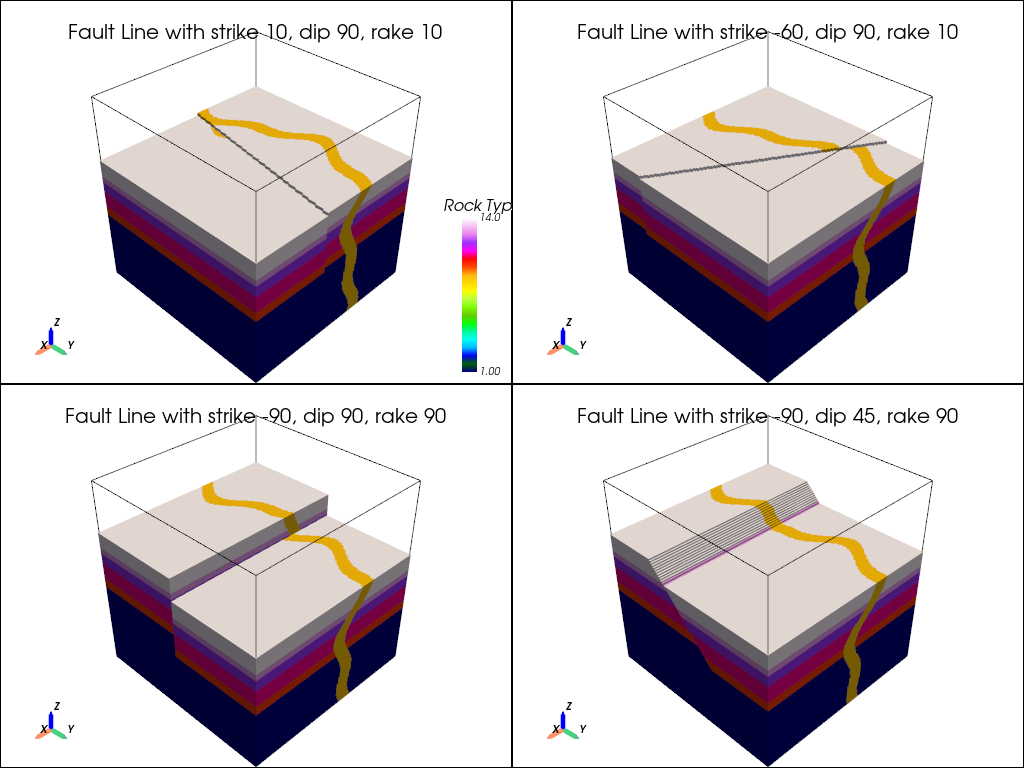

In [31]:
strike_dip_rake = [(10, 90, 10), (-60, 90, 10), (-90, 90, 90), (-90, 45, 90)]

p = pv.Plotter(shape=(2, 2))

for i, params in enumerate(strike_dip_rake):
    p.subplot(i // 2, i % 2)
    fault = geo.Fault(*params, amplitude=2.5, origin=(0, 0, 0))
    dike = geo.DikePlane(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fold, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(
        title=f"Fault Line with strike {params[0]}, dip {params[1]}, rake {params[2]}",
        font_size=8,
    )

p.show()

#### Shear
Shear is a continuous deformation modeled using a sigmoid function for a continuous deformation, with steepness controlled by the steepness parameter.

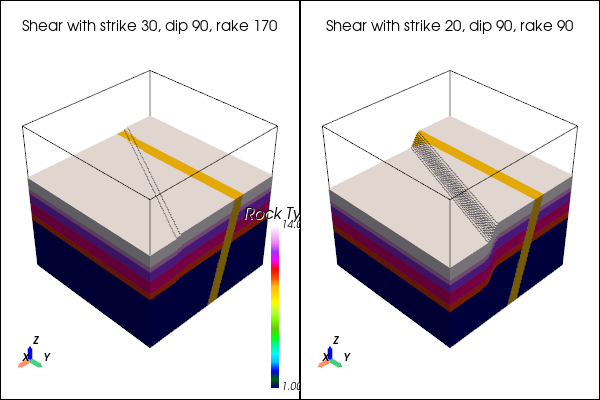

In [32]:
strike_dip_rake = [(30, 90, 170), (20, 90, 90)]

p = pv.Plotter(shape=(1, 2))
for i, params in enumerate(strike_dip_rake):
    p.subplot(0, i)
    fault = geo.Shear(*params, amplitude=4, origin=(0, 0, 0), steepness=2)
    dike = geo.DikePlane(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(
        title=f"Shear with strike {params[0]}, dip {params[1]}, rake {params[2]}",
        font_size=6,
    )

p.window_size = WS
p.show()

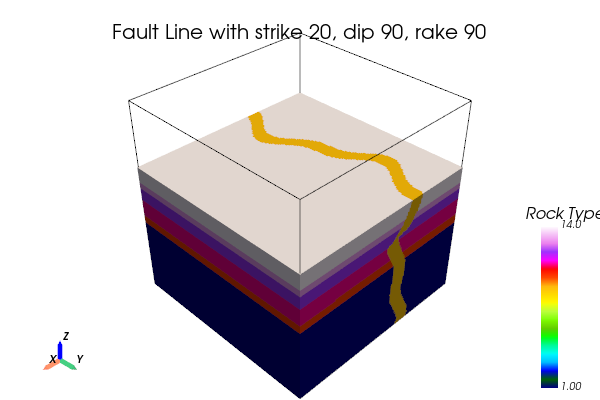

In [33]:
fault = geo.Fault(strike=0, dip=15, rake=10, amplitude=2.5, origin=(0, 0, 0))
dike = geo.DikePlane(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
history = [bedrock, sediment3, dike, fold, fault]
# make a new larger model
bounds = ((-20, 20), (-20, 20), (-20, 20))
model = geo.GeoModel(bounds=bounds, resolution=128)
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = WS
p.add_title(
    title=f"Fault Line with strike {params[0]}, dip {params[1]}, rake {params[2]}",
    font_size=8,
)
p.show()

### Additional Custom Slips
A custom slip can be made with a Slip GeoProcess. This is a function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements.

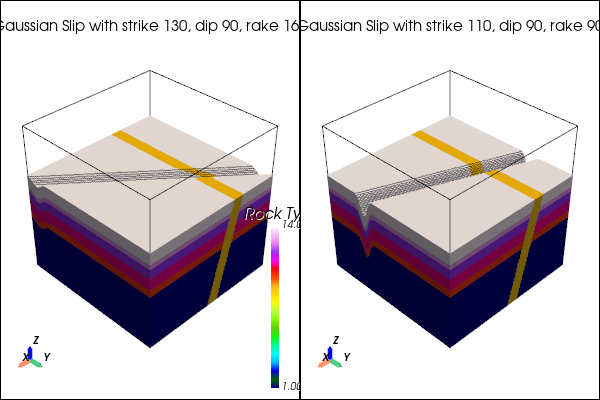

In [34]:
strike_dip_rake = [(130, 90, 160), (110, 90, 90)]

def gaussian_slip(distances, sigma=1.0):
    def custom_function(distances):
        return np.exp(-0.5 * (distances / sigma) ** 2)

    return custom_function

fun = gaussian_slip(1.0)

p = pv.Plotter(shape=(1, 2))
for i, params in enumerate(strike_dip_rake):
    p.subplot(0, i)
    fault = geo.Slip(fun, *params, amplitude=5, origin=(0, 0, 0))
    dike = geo.DikePlane(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    geovis.volview(model, plotter=p)
    p.add_title(
        title=f"Gaussian Slip with strike {params[0]}, dip {params[1]}, rake {params[2]}",
        font_size=6,
    )

p.window_size = WS
p.show()

### Unconformities

Unconformities are modeled using two options. A z-value can be specified where all material above that value is removed. Alternatively the highest point in the model can be determined and a downward removoval with specified depth can be used. 

First a model with layers and folds is computed and the two types of unconformities are applied.

In [35]:
# Period and amplitude modulate the passed function
fold2 = geo.Fold(strike=110, dip=90, rake=10, origin=(0, 0, 0), amplitude=2, period=30)
history = [bedrock, sediment2, dike, tilt, sediment3, fold2]
# make a new larger model
bounds = ((-20, 20), (-20, 20), (-20, 20))
model = geo.GeoModel(bounds=bounds, resolution=128)
model.clear_history()
model.add_history(history)

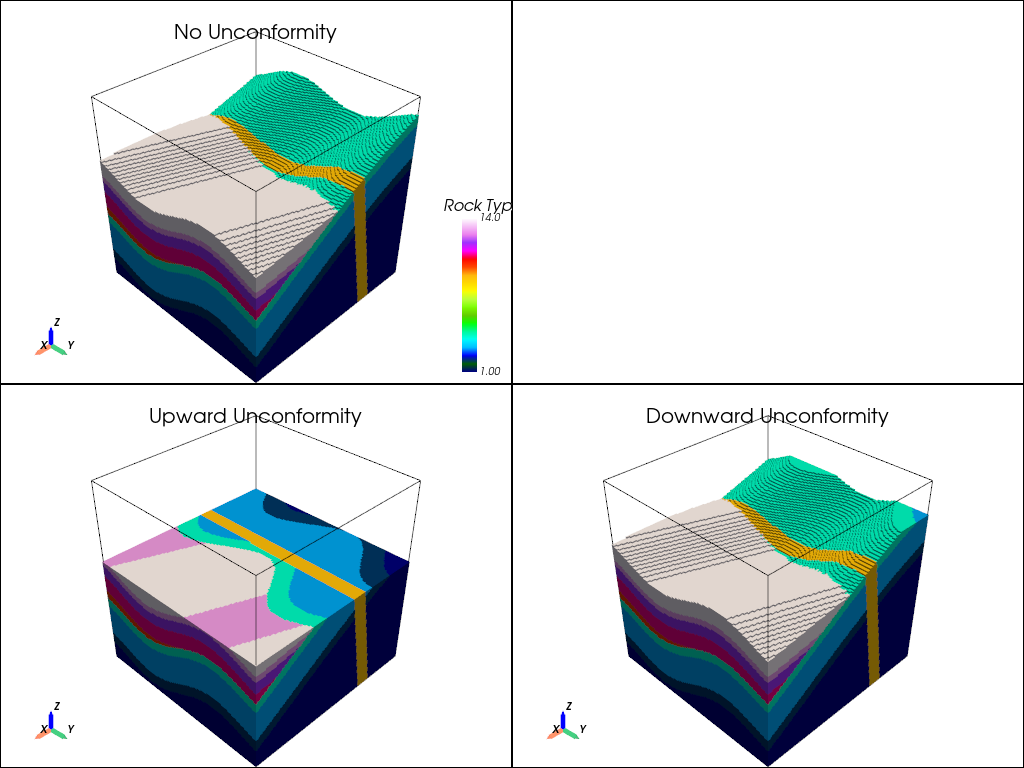

In [36]:
unc_up = geo.UnconformityBase(base=3)  # Erode rock above height 3
unc_down = geo.UnconformityDepth(depth=3)  # Erode rock down 3 units from highest point

p = pv.Plotter(shape=(2, 2))

# Compute and plot the model without any unconformities
model.compute_model()
p.subplot(0, 0)
geovis.volview(model, plotter=p)
p.add_title(title="No Unconformity", font_size=8)

# Compute and plot the model with an upward unconformity
model.clear_data()
model.add_history(unc_up)
model.compute_model()
p.subplot(1, 0)
geovis.volview(model, plotter=p)
p.add_title(title="Upward Unconformity", font_size=8)

# Compute and plot the model with a downward unconformity
model.clear_data()
model.history.pop()  # Remove the upward unconformity
model.add_history(unc_down)
model.compute_model()
p.subplot(1, 1)
geovis.volview(model, plotter=p)
p.add_title(title="Downward Unconformity", font_size=8)

p.show()

Although the base unconformity is a very simple removal, more interesting forms can be created by applying a change of coordinates using a transformation event on either side.

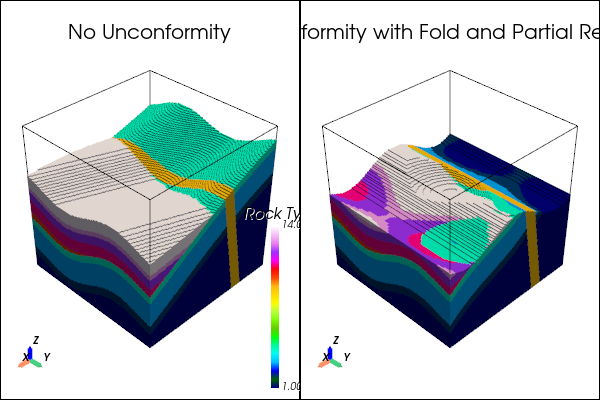

In [37]:
# Refresh a new model
fold2 = geo.Fold(strike=110, dip=90, rake=10, origin=(0, 0, 0), amplitude=2, period=30)
history = [bedrock, sediment2, dike, tilt, sediment3, fold2]
bounds = ((-20, 20), (-20, 20), (-20, 20))
model = geo.GeoModel(bounds=bounds, resolution=128)
model.clear_history()
model.add_history(history)
model.compute_model()

# Create no unconformity model for comparison
p = pv.Plotter(shape=(1, 2))
p.subplot(0, 0)
geovis.volview(model, plotter=p)
p.add_title(title="No Unconformity", font_size=8)

# Sandwich the unconformity between a fold and a partial reversal
fold_in = geo.Fold(strike=0, dip=90, rake=0, origin=(0, 0, 0), amplitude=4, period=30)
fold_out = geo.Fold(strike=0, dip=90, rake=0, origin=(0, 0, 0), amplitude=-3, period=30)
unc_rolling = [fold_in, unc_up, fold_out]

model.add_history(unc_rolling)
model.compute_model()

p.subplot(0, 1)
geovis.volview(model, plotter=p)
p.add_title(title="Unconformity with Fold and Partial Reversal", font_size=8)
p.window_size = WS
p.show()

### Organic Metaballs

The metaball process is a simple way to create organic shapes. The metaball consists of a set of balls with a defined radius, origin, and "goo_factor". Each point acts similar to a charge in an electric field, with the goo factor adjusting the rate of decay of the field relative to a benchmark of $\frac{1}{r^2}$. The potential of a single ball then is $\left( \frac{b}{r^2} \right)^{g}$ where $b$ is the ball radius and $g$ is a goo factor.

The potential at a point is the sum of the potentials of all the balls: 
$$V(x,y,z) = \sum_i \left( \frac{b_{i}}{r_i^2} \right)^{g_i}$$

A higher goo factor will cause the field to decay more rapidly. 

Individual balls can be defined, or a list of balls can be iteratively generated using a random walk process. The BallListGenerator is a random generator class designed to produce organic shapes that can be embedded into a model. 

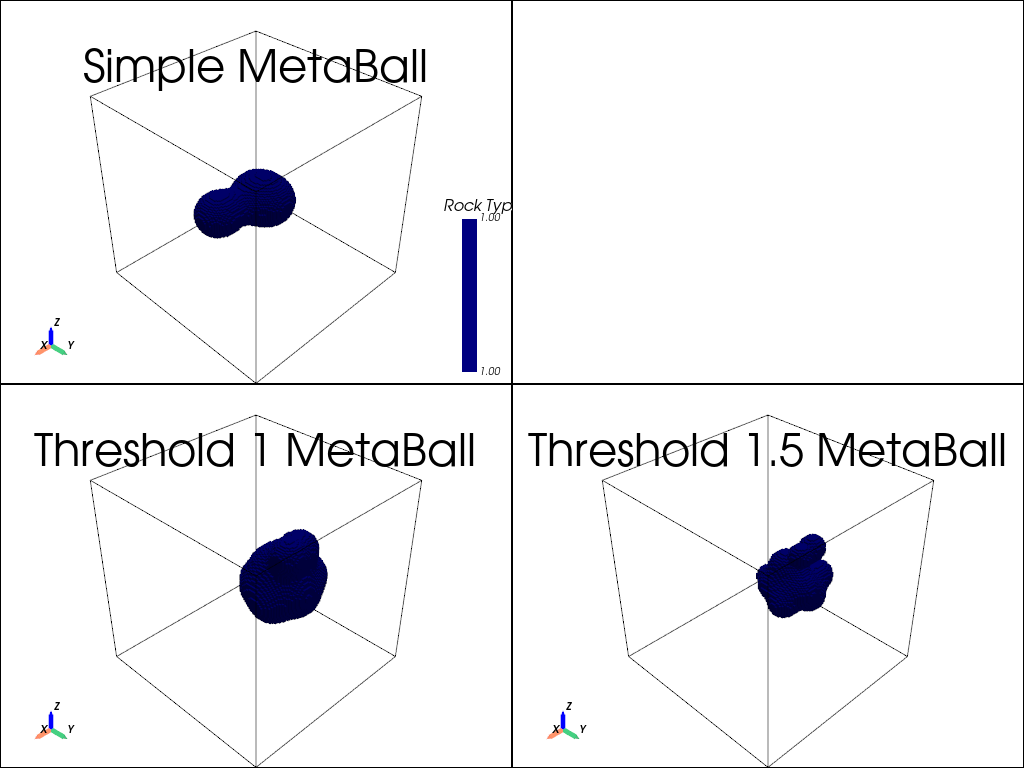

In [38]:
p = pv.Plotter(shape=(2, 2))
# simple test with three balls
gf = 0.8
ball1 = geo.Ball(origin=[0, 0, 0], radius=2, goo_factor=gf)
ball2 = geo.Ball(origin=[5, 0, 0], radius=3, goo_factor=gf)
ball3 = geo.Ball(origin=[0, 2, 0], radius=3, goo_factor=gf)
balls = [ball1, ball2, ball3]

metaball = geo.MetaBall(balls=balls, threshold=1, value=1)
model = geo.GeoModel(bounds=(-10, 10), resolution=128)
model.add_history(metaball)
model.compute_model()

p.subplot(0, 0)
geovis.volview(model, threshold=-0.5, plotter=p)
p.add_title("Simple MetaBall")

# -- Generative Balls Test -- #
# Make a starting list of balls generatively and create a deterministic MetaBall object
ballgen = geo.BallListGenerator(step_range=[2, 3], rad_range=[1, 1], goo_range=[0.8, 1])
balls = ballgen.generate(n_balls=12, origin=[0, 0, 0])

# Threshold 1 MetaBall
metaball = geo.MetaBall(balls=balls, threshold=1, value=1)
model = geo.GeoModel(bounds=(-10, 10), resolution=128)
model.add_history(metaball)
model.compute_model()

p.subplot(1, 0)
geovis.volview(model, threshold=-0.5, plotter=p)
p.add_title("Threshold 1 MetaBall")

# Redo with a higher threshold
metaball = geo.MetaBall(balls=balls, threshold=1.5, value=1)
model = geo.GeoModel(bounds=(-10, 10), resolution=128)
model.add_history(metaball)
model.compute_model()

p.subplot(1, 1)
geovis.volview(model, threshold=-0.5, plotter=p)
p.add_title("Threshold 1.5 MetaBall")
p.show()